In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA, KernelPCA
import optuna

import sys
sys.path.append("../") # go to parent dir

from src.debiasing import DebiasingPCA
from src.debiasing import DebiasingKPCA
from src.debiasing import NumpyDebiasingKernelPCA
from src.debiasing.utils import get_design_matrix

In [2]:
data = pd.read_csv("../data/CoLA/mixed_dev_embeddings.tsv", sep="\t")
data = data.sort_values(by='defining set id')
X = data.iloc[:, 3:771].to_numpy()
X_index = data['defining set id'].to_numpy()

In [3]:
print("the shape of X:", X.shape)
X

the shape of X: (640, 768)


array([[-0.851718  , -0.4793546 , -0.77166116, ..., -0.5383287 ,
        -0.76654   ,  0.9239464 ],
       [-0.84405816, -0.49862942, -0.7877743 , ..., -0.57809174,
        -0.728355  ,  0.9136135 ],
       [-0.87432224, -0.59713227, -0.9513105 , ..., -0.40138096,
        -0.7750305 ,  0.8731641 ],
       ...,
       [-0.886508  , -0.51329815, -0.94088244, ..., -0.75856566,
        -0.7137282 ,  0.9045762 ],
       [-0.70865357, -0.30252996, -0.819484  , ..., -0.36328802,
        -0.6049608 ,  0.7728163 ],
       [-0.7912138 , -0.4454564 , -0.92030555, ..., -0.6560643 ,
        -0.64869297,  0.8218555 ]])

In [4]:
print("the shape of X_ index:", X_index.shape)
X_index

the shape of X_ index: (640,)


array([  0,   0,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,
         6,   7,   7,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,
        13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  18,  18,  19,
        19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,  25,  25,
        26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,
        32,  33,  33,  34,  34,  35,  35,  36,  36,  37,  37,  38,  38,
        39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,  44,  45,
        45,  46,  46,  47,  47,  48,  48,  49,  49,  50,  50,  51,  51,
        52,  52,  53,  53,  54,  54,  55,  55,  56,  56,  57,  57,  58,
        58,  59,  59,  60,  60,  61,  61,  62,  62,  63,  63,  64,  64,
        65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,  70,  71,
        71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
        78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  83,  84,
        84,  85,  85,  86,  86,  87,  87,  88,  88,  89,  89,  9

Text(0.5, 0, 'the number of components')

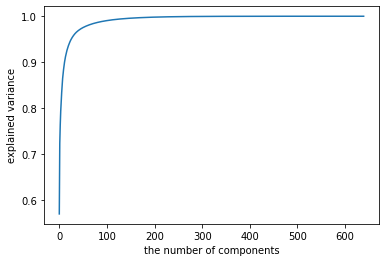

In [5]:
# data visualization
eigvals = PCA().fit(X).explained_variance_
explained_var = np.cumsum(eigvals) / np.sum(eigvals)
plt.plot(explained_var)
plt.ylabel('explained variance')
plt.xlabel('the number of components')

# PCA debiasing

In [6]:
debiaser = DebiasingPCA(n_components=3)
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [7]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(327.8692835741753, 426.1726765040533, 272.25885309239357)

# Kernel PCA debiasing (by optimization-based pre-imaging)

In [9]:
debiaser = DebiasingKPCA(n_components=2)
debiaser.fit(X, X_index)

# to prevent out of memory error, we aplit the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=0.1, n_iter=100)

../src/debiasing/torch_kpca.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


In [10]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(523.6302109198584, 426.1726765040533, 346.45579222971855)

In [11]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(2.282528862953122, 4.864261281165231)

# Appendices

## Kernel PCA debiasing (by kernel ridge pre-imaging)

In [17]:
np.linalg.norm(X)

426.1726765040533

### Unsuccessful case (Learn pre-image of bias subspace by min || Phi(w) - Proj (Phi(w))||)

In [18]:
debiaser = NumpyDebiasingKernelPCA(n_components=3, kernel="rbf")
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [19]:
np.linalg.norm(X_debiased)

63.74915566837997

### OK case (Learn pre-image of bias subspace by min || Phi(w - m) - Proj (Phi(w - m))||)

In [20]:
DX = get_design_matrix(X_index)
X_diff = DX @ X
kpca = KernelPCA(n_components=3, kernel="rbf", gamma=0.14, fit_inverse_transform=True)
kpca.fit(X_diff)
X_bias = kpca.inverse_transform(kpca.transform(X))
X_debiased = X - X_bias

In [21]:
np.linalg.norm(X_debiased)

425.8716657453607

# Parameter Selection of the RBF kernel

In [ ]:
# gamma = 0.14 seems to work well

def objective(trial):
    # n = trial.suggest_int("n_components", 1, 30)
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e+3)
    kpca = KernelPCA(n_components=3, kernel="rbf", gamma=gamma, fit_inverse_transform=True)
    kpca.fit(X_diff[:400])
    X_reproj = kpca.inverse_transform(kpca.transform(X_diff[400:]))
    return np.linalg.norm(X_diff[400:] - X_reproj)

study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(study.best_params)

# Parameter Selection of DebiasingKPCA.debias()

In [ ]:
import optuna

def objective(trial):
    
    lr = trial.suggest_loguniform('lr', 5e-3, 1.)
    n_iter = trial.suggest_int('n_iter', 3, 50, log=True)
    n_components = trial.suggest_int('n_component', 1, 20)
    
    debiaser = DebiasingKPCA(n_components)
    debiaser.fit(X, X_index)

    # to prevent out of memory error, we aplit the data into smaller chanks
    X_debiased = np.empty(X.shape)
    BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
    NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
    for i in range(NB):
        X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=lr, n_iter=n_iter)
    
    original_bias = np.linalg.norm(debiaser.transform(X))
    reduced_bias = np.linalg.norm(debiaser.transform(X_debiased))
    
    diff_norm = np.linalg.norm(X_debiased - X)
    orig_norm = np.linalg.norm(X)
    
    obj_val = np.log(original_bias) - np.log(reduced_bias)
    return - obj_val

In [ ]:
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=40)

In [ ]:
study.best_params

In [ ]:
debiaser = DebiasingKPCA(n_components=9)
debiaser.fit(X, X_index)

# to prevent out of memory error, we aplit the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=0.3, n_iter=33)

In [ ]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

In [ ]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

In [22]:
debiaser = DebiasingKPCA(n_components=1)
debiaser.fit(X, X_index)

# to prevent out of memory error, we aplit the data into smaller chanks
X_debiased = np.empty(X.shape)
BS = 320  # maximal possible batch size for GPU with 8gb memory in my local env.
NB = int(np.ceil(X.shape[0] / BS))  # the number of batches
for i in range(NB):
    X_debiased[BS*i: BS*(i+1)] = debiaser.debias(X[BS*i: BS*(i+1)], lr=0.3, n_iter=30)

../src/debiasing/torch_kpca.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


In [23]:
np.linalg.norm(X_debiased), np.linalg.norm(X), np.linalg.norm(X_debiased - X)

(854.4333185435321, 426.1726765040533, 775.7350428499904)

In [24]:
np.linalg.norm(debiaser.transform(X_debiased)), np.linalg.norm(debiaser.transform(X))

(0.6177560537380387, 2.5792365570250717)